In [14]:
import torch
from torchvision import datasets, transforms
import helper

Downloading the data!

In [15]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

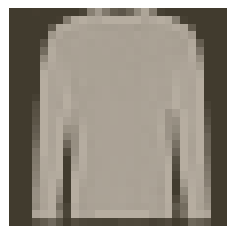

In [16]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

### Building the network:

In [17]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [18]:
model = Classifier()

images, labels = next(iter(testloader))
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


In [19]:
top_p, top_class = ps.topk(1, dim=1)
equals = top_class == labels.view(*top_class.shape)

##### Checking the accuracy of our untrained data:

In [20]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


### Training the network:

In [21]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.519..  Test Loss: 0.463..  Test Accuracy: 0.832
Epoch: 2/30..  Training Loss: 0.393..  Test Loss: 0.431..  Test Accuracy: 0.842
Epoch: 3/30..  Training Loss: 0.361..  Test Loss: 0.388..  Test Accuracy: 0.862
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.388..  Test Accuracy: 0.863
Epoch: 5/30..  Training Loss: 0.321..  Test Loss: 0.367..  Test Accuracy: 0.868
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.374..  Test Accuracy: 0.869
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.392..  Test Accuracy: 0.866
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.385..  Test Accuracy: 0.867
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.379..  Test Accuracy: 0.874
Epoch: 10/30..  Training Loss: 0.269..  Test Loss: 0.356..  Test Accuracy: 0.878
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.360..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.251..  Test Loss: 0.366..  Test Accuracy: 0.875
Epoch: 13/30..  Training Loss: 0.250.

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

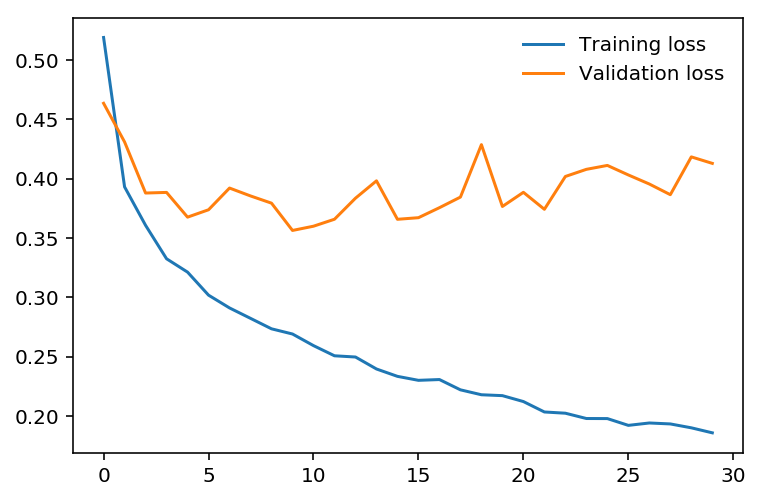

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. 

### Adding DROPOUT to out model:

#### Building the newtork with DROPOUT:

In [24]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

#### Training the network with DROPOUT:

In [25]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.612..  Test Loss: 0.490..  Test Accuracy: 0.821
Epoch: 2/30..  Training Loss: 0.476..  Test Loss: 0.439..  Test Accuracy: 0.847
Epoch: 3/30..  Training Loss: 0.454..  Test Loss: 0.423..  Test Accuracy: 0.848
Epoch: 4/30..  Training Loss: 0.433..  Test Loss: 0.423..  Test Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.416..  Test Loss: 0.393..  Test Accuracy: 0.861
Epoch: 6/30..  Training Loss: 0.405..  Test Loss: 0.407..  Test Accuracy: 0.863
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.403..  Test Accuracy: 0.856
Epoch: 8/30..  Training Loss: 0.395..  Test Loss: 0.385..  Test Accuracy: 0.861
Epoch: 9/30..  Training Loss: 0.392..  Test Loss: 0.380..  Test Accuracy: 0.864
Epoch: 10/30..  Training Loss: 0.386..  Test Loss: 0.382..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.376..  Test Loss: 0.386..  Test Accuracy: 0.865
Epoch: 12/30..  Training Loss: 0.383..  Test Loss: 0.387..  Test Accuracy: 0.862
Epoch: 13/30..  Training Loss: 0.373.

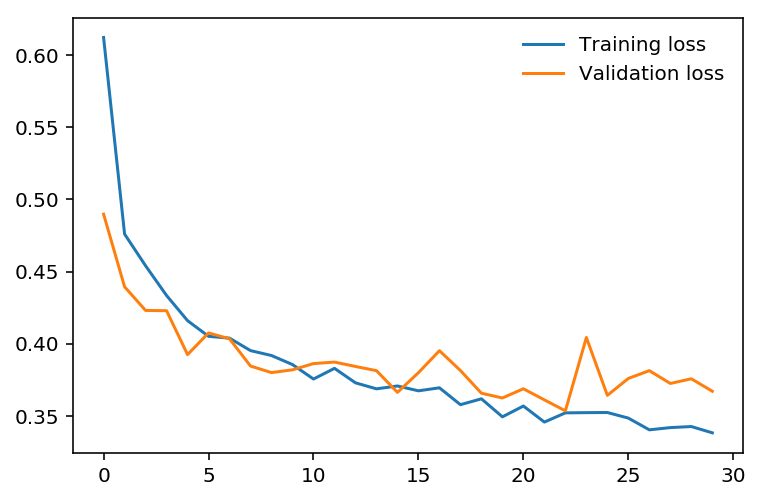

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Now, we can see that the training loss sticks a lot closer to the train loss as we train. Hence, with dropout we have managed to atleast reduce overfitting.  